In [1]:
import h2o
import operator
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
from matplotlib import pyplot as plt
from pycebox.ice import ice, ice_plot
import warnings
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators import H2OGradientBoostingEstimator
warnings.filterwarnings("ignore")

# 1 Data Preparation

## 1.1 H2O Initialization

In [2]:
pct_memory=4
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

29


In [3]:
h2o.init(strict_version_check=False,max_mem_size=min_mem_size)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "10.0.2" 2018-07-17; Java(TM) SE Runtime Environment 18.3 (build 10.0.2+13); Java HotSpot(TM) 64-Bit Server VM 18.3 (build 10.0.2+13, mixed mode)
  Starting server from /anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/5l/qqvypzcs2sjbbnhb777lxczh0000gn/T/tmpa4e4f9_f
  JVM stdout: /var/folders/5l/qqvypzcs2sjbbnhb777lxczh0000gn/T/tmpa4e4f9_f/h2o_mandy_started_from_python.out
  JVM stderr: /var/folders/5l/qqvypzcs2sjbbnhb777lxczh0000gn/T/tmpa4e4f9_f/h2o_mandy_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,21 days and 24 minutes
H2O cluster name:,H2O_from_python_mandy_ktbc53
H2O cluster total nodes:,1
H2O cluster free memory:,29 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"accepting new members, healthy"


## 1.2 Data Import & Parse

In [4]:
data_path = "AmazonReviews.Small.csv"

# Load data into H2O
reviews = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [5]:
reviews.shape

(55554, 10)

In [6]:
reviews.head(3)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one."
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring."
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)"


In [7]:
reviews['PositiveReview']=(reviews['Score']>=reviews['Score'].mean()[0]).ifelse('1','0')

In [8]:
reviews['PositiveReview'].table()

PositiveReview,Count
0,20106
1,35448


In [9]:
# Find the 80th quantile of time in the dataset
time_split = reviews["Time"].quantile(prob = [0.8])[1]
reviews["Train"] = (reviews["Time"] < time_split).ifelse("Yes", "No")

In [10]:
reviews['Train'].table()

Train,Count
No,11152
Yes,44402


In [11]:
train = reviews[reviews["Train"] == "Yes"]
test = reviews[reviews["Train"] == "No"]

## 1.3 Tokenize Words in Review

In [18]:
data_path = "stopwords.csv"
STOP_WORDS = pd.read_csv(data_path, header=0)

In [19]:
STOP_WORDS.head()

,STOP_WORD
0,all
1,just
2,being
3,over
4,both


In [20]:
STOP_WORDS = list(STOP_WORDS['STOP_WORD'])

In [21]:
def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words

In [22]:
# Break reviews into sequence of words
words = tokenize(reviews["Text"])

In [23]:
words.head()

C1
made
china
buy
pet
food
china
dogswell
using
propylene
glycol


## 1.4 Word2Vec Model

In [24]:
# Train Word2Vec Model
from h2o.estimators.word2vec import H2OWord2vecEstimator


w2v_model = H2OWord2vecEstimator(vec_size = 100, model_id = "w2v.hex")
w2v_model.train(training_frame=words)

models_path='data'
h2o.save_model(w2v_model, path = models_path, force = True)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


'/Users/mandy/Documents/Study/AI-Addin/data/w2v.hex'

In [25]:
# Sanity check - find synonyms for the word 'coffee'
w2v_model.find_synonyms("coffee", count = 5)

OrderedDict([('coffe', 0.8146992325782776),
             ('coffees', 0.7962262630462646),
             ('espresso', 0.7765772938728333),
             ('esspresso', 0.7470539212226868),
             ('wakeup', 0.738392174243927)])

In [26]:
# Sanity check - find synonyms for the word 'stale'
w2v_model.find_synonyms("stale", count = 5)

OrderedDict([('rancid', 0.6665993928909302),
             ('inedible', 0.6664527058601379),
             ('unedible', 0.642181932926178),
             ('tasteless', 0.6371230483055115),
             ('moldy', 0.6223236322402954)])

In [27]:
# Calculate a vector for each review
review_vecs = w2v_model.transform(words, aggregate_method = "AVERAGE")
review_vecs

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
0.0410499,-0.146204,-0.285427,0.0254471,0.117685,-0.0448131,-0.0521254,-0.122815,0.0376127,0.0109521,-0.102133,-0.0486561,-0.0621305,-0.00975907,-0.00570562,-0.180623,-0.020774,-0.0411431,-0.0147853,-0.0971181,-0.0159122,-0.0193051,0.00314792,0.0954248,0.116065,0.140936,0.116127,-0.00374543,-0.215285,-0.0270248,0.0119914,0.247401,0.183703,0.0868549,0.0103296,0.0208145,0.122103,-0.0928743,-0.0100389,-0.11856,0.186428,-0.163182,0.149529,-0.0539655,0.0085114,-0.141806,-0.224711,-0.0691101,-0.0657561,-0.0169354,0.150188,-0.0732323,-0.0405487,0.0943669,-0.0395443,-0.0328437,-0.0313897,0.111981,0.244707,0.00756712,-0.280116,0.249046,-0.0632348,-0.201192,0.0891857,-0.113636,-0.0861205,0.0403625,0.0984312,0.0624902,0.00508377,-0.122918,0.0713066,-0.156134,-0.12461,0.0667455,-0.0425776,0.00643421,0.117664,-0.148929,0.0787482,-0.0875336,0.106674,-0.00888346,0.00183531,0.0121721,0.0960461,0.108515,-0.00934751,0.0343095,-0.0163497,0.0758473,-0.0762475,0.0400815,-0.0198935,-0.179636,0.04466,-0.0747715,-0.051563,0.086337
-0.0168731,0.205152,0.0178846,-0.00401017,0.186377,0.0609719,-0.0516552,-0.146039,-0.10241,-0.002283,-0.022299,-0.0561087,0.059518,-0.0687224,-0.0222154,-0.056836,0.140548,-0.00527059,-0.0311035,0.0584353,0.13725,0.143233,-0.048869,-0.0309075,0.0710254,-0.0930747,0.0651379,0.112067,0.104425,-0.083902,0.122894,0.0849256,0.237759,0.00813777,-0.02785,0.0416097,-0.0274384,-0.105021,0.000200458,-0.279208,0.182049,0.0156211,0.232548,-0.0410957,-0.0394131,-0.119328,-0.139742,-0.0800661,-0.114642,-0.0899811,0.0299466,-0.266682,0.0116383,0.235033,0.0166786,-0.0832042,0.107546,0.0669999,0.204786,0.155993,-0.192578,0.0450506,-0.0932742,-0.0258353,0.0131895,0.0182733,-0.078868,-0.18508,0.0709706,-0.0838733,-0.0803538,0.042668,0.166175,-0.172344,0.0344755,0.0963614,-0.00450752,0.0286235,0.0173997,-0.222903,0.0598912,0.00692643,-0.0550072,0.0250324,-0.037459,-0.0218965,-0.0404033,0.127231,-0.0254501,0.173607,-0.0308788,0.0493804,-0.078108,-0.0384999,0.000911163,-0.17991,-0.168636,-0.134576,0.014041,0.110885
0.0912552,-0.0270904,-0.105998,0.117295,0.0426804,-0.0201742,-0.0602782,0.0473378,0.0295703,-0.0118265,-0.0968422,-0.0164974,-0.0199767,0.106042,-0.0378111,-0.00356926,0.0359349,-0.0219406,0.00714618,-0.0624658,-0.0283937,0.0175243,-0.0536904,0.0910684,0.0705079,-0.00438208,0.0764417,-0.023922,0.00313756,-0.023761,0.0115935,0.162139,0.230323,-0.00402018,-0.0225697,-0.0798728,0.0338326,-0.00579746,0.0887428,-0.0734863,0.0442663,-0.136482,0.234298,-0.0323383,-0.10865,-0.203888,-0.126513,-0.0637946,-0.02811,-0.0212629,0.134549,-0.251012,0.0506457,0.0595697,-0.0397004,-0.0316828,-0.0702738,0.0479181,0.102396,-0.00698299,-0.190544,0.220229,-0.0110431,-0.106953,-0.10391,0.0218054,-0.125348,-0.14713,0.129716,-0.0167192,0.124648,-0.0890766,0.204822,-0.196557,-0.157732,0.0761307,0.0466672,0.0122299,0.000125276,-0.208611,0.0923396,-0.0229839,0.0148204,-0.0100454,-0.14896,-0.0652911,0.232896,0.141152,-0.0368149,0.0577446,0.0432447,0.147477,-0.115366,0.0207088,-0.0897639,-0.145678,0.0167911,-0.155149,0.0189327,0.157371
0.0506611,-0.0137952,-0.0842045,0.0783967,0.172741,-0.0334506,-0.0180625,0.094259,0.0533953,-0.150385,-0.00880885,0.0320596,0.0450748,1.22293e-05,0.0389893,-0.0374257,0.106436,-0.0834178,-0.013194,-0.0867779,-0.0395077,-0.0497283,0.0231751,0.00448363,0.023539,0.0412272,0.0771422,0.0656852,-0.0597668,-0.0743301,-0.0167046,0.104726,0.198659,-0.0536984,-0.107521,0.0628731,0.166905,-0.0610736,0.150174,-0.125526,-0.0320474,-0.196611,0.145083,0.0185329,-0.119173,-0.152929,-0.182173,-0.0532022,0.00317026,-0.0174073,0.107379,-0.261378,-0.0386492,0.094654,

In [28]:
# Add aggregated word embeddings 
ext_reviews = reviews.cbind(review_vecs)

In [29]:
ext_reviews.head(3)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview,Train,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0,No,0.0410499,-0.146204,-0.285427,0.0254471,0.117685,-0.0448131,-0.0521254,-0.122815,0.0376127,0.0109521,-0.102133,-0.0486561,-0.0621305,-0.00975907,-0.00570562,-0.180623,-0.020774,-0.0411431,-0.0147853,-0.0971181,-0.0159122,-0.0193051,0.00314792,0.0954248,0.116065,0.140936,0.116127,-0.00374543,-0.215285,-0.0270248,0.0119914,0.247401,0.183703,0.0868549,0.0103296,0.0208145,0.122103,-0.0928743,-0.0100389,-0.11856,0.186428,-0.163182,0.149529,-0.0539655,0.0085114,-0.141806,-0.224711,-0.0691101,-0.0657561,-0.0169354,0.150188,-0.0732323,-0.0405487,0.0943669,-0.0395443,-0.0328437,-0.0313897,0.111981,0.244707,0.00756712,-0.280116,0.249046,-0.0632348,-0.201192,0.0891857,-0.113636,-0.0861205,0.0403625,0.0984312,0.0624902,0.00508377,-0.122918,0.0713066,-0.156134,-0.12461,0.0667455,-0.0425776,0.00643421,0.117664,-0.148929,0.0787482,-0.0875336,0.106674,-0.00888346,0.00183531,0.0121721,0.0960461,0.108515,-0.00934751,0.0343095,-0.0163497,0.0758473,-0.0762475,0.0400815,-0.0198935,-0.179636,0.04466,-0.0747715,-0.051563,0.086337
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring.",0,Yes,-0.0168731,0.205152,0.0178846,-0.00401017,0.186377,0.0609719,-0.0516552,-0.146039,-0.10241,-0.002283,-0.022299,-0.0561087,0.059518,-0.0687224,-0.0222154,-0.056836,0.140548,-0.00527059,-0.0311035,0.0584353,0.13725,0.143233,-0.048869,-0.0309075,0.0710254,-0.0930747,0.0651379,0.112067,0.104425,-0.083902,0.122894,0.0849256,0.237759,0.00813777,-0.02785,0.0416097,-0.0274384,-0.105021,0.000200458,-0.279208,0.182049,0.0156211,0.232548,-0.0410957,-0.0394131,-0.119328,-0.139742,-0.0800661,-0.114642,-0.0899811,0.0299466,-0.266682,0.0116383,0.235033,0.0166786,-0.0832042,0.107546,0.0669999,0.204786,0.155993,-0.192578,0.0450506,-0.0932742,-0.0258353,0.0131895,0.0182733,-0.078868,-0.18508,0.0709706,-0.0838733,-0.0803538,0.042668,0.166175,-0.172344,0.0344755,0.0963614,-0.00450752,0.0286235,0.0173997,-0.222903,0.0598912,0.00692643,-0.0550072,0.0250324,-0.037459,-0.0218965,-0.0404033,0.127231,-0.0254501,0.173607,-0.0308788,0.0493804,-0.078108,-0.0384999,0.000911163,-0.17991,-0.168636,-0.134576,0.014041,0.110885
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)",1,Yes,0.0912552,-0.0270904,-0.105998,0.117295,0.0426804,-0.0201742,-0.0602782,0.0473378,0.0295703,-0.0118265,-0.0968422,-0.0164974,-0.0199767,0.106042,-0.0378111,-0.00356926,0.0359349,-0.0219406,0.00714618,-0.0624658,-0.0283937,0.0175243,-0.0536904,0.0910684,0.0705079,-0.00438208,0.0764417,-0.023922,0.00313756,-0.023761,0.0115935,0.162139,0.230323,-0.00402018,-0.0225697,-0.0798728,0.0338326,-0.005

## 1.5 Add Summary Column

In [31]:
# Break summaries into sequence of word.
summary_words = tokenize(reviews['Summary'].ascharacter())

In [32]:
summary_vecs = w2v_model.transform(summary_words, aggregate_method='AVERAGE')
summary_vecs.names = ['summary_'+ s for s in summary_vecs.names]

ext_reviews_new = ext_reviews.cbind(summary_vecs)

In [33]:
ext_reviews_new.head(3)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview,Train,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100,summary_C1,summary_C2,summary_C3,summary_C4,summary_C5,summary_C6,summary_C7,summary_C8,summary_C9,summary_C10,summary_C11,summary_C12,summary_C13,summary_C14,summary_C15,summary_C16,summary_C17,summary_C18,summary_C19,summary_C20,summary_C21,summary_C22,summary_C23,summary_C24,summary_C25,summary_C26,summary_C27,summary_C28,summary_C29,summary_C30,summary_C31,summary_C32,summary_C33,summary_C34,summary_C35,summary_C36,summary_C37,summary_C38,summary_C39,summary_C40,summary_C41,summary_C42,summary_C43,summary_C44,summary_C45,summary_C46,summary_C47,summary_C48,summary_C49,summary_C50,summary_C51,summary_C52,summary_C53,summary_C54,summary_C55,summary_C56,summary_C57,summary_C58,summary_C59,summary_C60,summary_C61,summary_C62,summary_C63,summary_C64,summary_C65,summary_C66,summary_C67,summary_C68,summary_C69,summary_C70,summary_C71,summary_C72,summary_C73,summary_C74,summary_C75,summary_C76,summary_C77,summary_C78,summary_C79,summary_C80,summary_C81,summary_C82,summary_C83,summary_C84,summary_C85,summary_C86,summary_C87,summary_C88
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0,No,0.0410499,-0.146204,-0.285427,0.0254471,0.117685,-0.0448131,-0.0521254,-0.122815,0.0376127,0.0109521,-0.102133,-0.0486561,-0.0621305,-0.00975907,-0.00570562,-0.180623,-0.020774,-0.0411431,-0.0147853,-0.0971181,-0.0159122,-0.0193051,0.00314792,0.0954248,0.116065,0.140936,0.116127,-0.00374543,-0.215285,-0.0270248,0.0119914,0.247401,0.183703,0.0868549,0.0103296,0.0208145,0.122103,-0.0928743,-0.0100389,-0.11856,0.186428,-0.163182,0.149529,-0.0539655,0.0085114,-0.141806,-0.224711,-0.0691101,-0.0657561,-0.0169354,0.150188,-0.0732323,-0.0405487,0.0943669,-0.0395443,-0.0328437,-0.0313897,0.111981,0.244707,0.00756712,-0.280116,0.249046,-0.0632348,-0.201192,0.0891857,-0.113636,-0.0861205,0.0403625,0.0984312,0.0624902,0.00508377,-0.122918,0.0713066,-0.156134,-0.12461,0.0667455,-0.0425776,0.00643421,0.117664,-0.148929,0.0787482,-0.0875336,0.106674,-0.00888346,0.00183531,0.0121721,0.0960461,0.108515,-0.00934751,0.0343095,-0.0163497,0.0758473,-0.0762475,0.0400815,-0.0198935,-0.179636,0.04466,-0.0747715,-0.051563,0.086337,0.201034,0.04862,0.0322846,0.1717,0.176998,0.102274,-0.0149814,-0.0160084,-0.200739,0.197971,-0.0647588,-0.0908953,-0.159827,-0.159446,-0.171669,0.127379,0.156348,0.0982737,0.0290098,0.0380551,0.0836924,0.0108417,-0.0267286,0.0834928,0.269171,-0.100711,-0.0201106,0.1644,-0.0922762,-0.142686,0.222742,0.262842,0.285044,0.194881,0.023707,0.152735,0.273157,0.11064,-0.160933,-0.0246083,0.357006,-0.383642,0.348962,0.00377666,0.0432101,-0.0822788,-0.47511,-0.0859422,0.083014,-0.165104,0.139594,-0.200091,-0.00944079,-0.0181709,0.0247414,-0.0338022,0.0119891,-0.0151318,0.36178,-0.202999,-0.156567,0.0578563,-0.153071,-0.255589,0.0930879,-0.00107657,-0.28325,-0.0716239,-0.0143438,-0.191867,-0.0131288,-0.295636,0.230921,-0.208801,0.0624483,0.074903,-0.0163599,0.0145924,0.0659399,0.00754669,0.393506,0.123485,0.257096,0.0365595,0.0295972,0.198292,-0.0190884,0.0129937
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok,

In [34]:
ext_train_new = ext_reviews_new[ext_reviews_new["Train"] == "Yes"]
ext_test_new = ext_reviews_new[ext_reviews_new["Train"] == "No"]

# 2 Training Models

## 2.1 Linear Regression

### 2.1.1 Train & Fit Model

In [24]:
predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time'] + summary_vecs.names + review_vecs.names 
response = 'PositiveReview'

In [25]:
# Initialize
local_glm_plus = H2OGeneralizedLinearEstimator(family='binomial', model_id='glm_surrogate', lambda_search=True)
# train 
local_glm_plus.train(x=predictors, y=response, training_frame=ext_train_new)

glm Model Build progress: |███████████████████████████████████████████████| 100%


### 2.1.2 Interpretability

#### Vaviable Importance

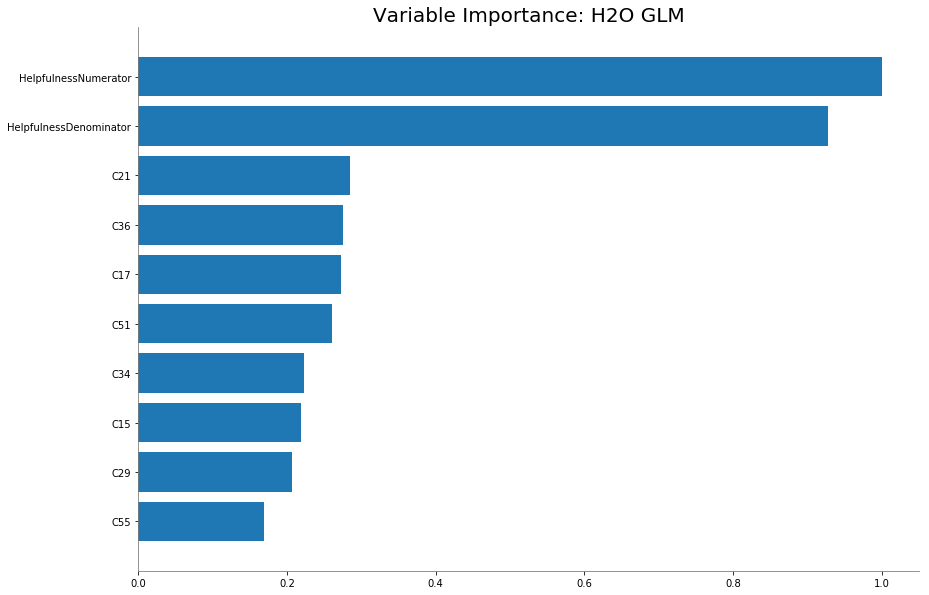

In [26]:
local_glm_plus.varimp_plot()

#### Partial Dependence Plot (PDP)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


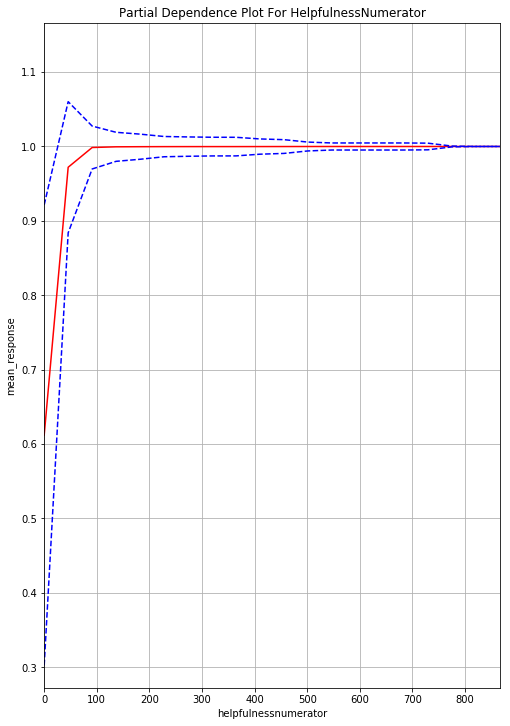

In [28]:
pdp_local_linear_plus = local_glm_plus.partial_plot(data = ext_train_new, cols = ["HelpfulnessNumerator"])

#### Individual Conditional Expectation (ICE)

In [52]:
ice_linear = ice(ext_train_new, 'HelpfulnessNumerator', local_glm_plus.predict, num_grid_points=100)

AttributeError: 'H2OFrame' object has no attribute 'values'

### 2.1.3 Matrix

In [29]:
print('\nLocal GLM Coefficients:')
for c_name, c_val in sorted(local_glm_plus.coef().items(), key=operator.itemgetter(1)):
    if c_val != 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))


Local GLM Coefficients:
C21:                      -4.367109075022356
C29:                      -3.1352780319828635
C51:                      -3.1204999574616368
C30:                      -3.1158708397698898
C55:                      -2.84341696256946
C34:                      -2.6777491618688134
C9:                       -2.6287326962273734
C3:                       -2.326112489633461
C83:                      -2.109372710883918
C98:                      -2.003911628288666
C39:                      -1.7824873571546964
C82:                      -1.590938065907688
C53:                      -1.5869125734562428
C69:                      -1.461196010323064
C67:                      -1.4595398702408677
C11:                      -1.4556118577877177
C26:                      -1.4207731398806778
C95:                      -1.3073384376050694
summary_C21:              -1.1193828358928604
C89:                      -1.1180151412914847
C28:                      -1.0373585246576182
C59:             

In [30]:
local_glm_plus.r2(train=True, valid=True)

{'train': 0.4333032337729773, 'valid': None}

In [31]:
local_glm_plus.auc()

0.8770051173350655

In [32]:
local_glm_plus.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4665592179349771: 


,0,1,Error,Rate
0,10213.0,5681.0,0.3574,(5681.0/15894.0)
1,2318.0,26190.0,0.0813,(2318.0/28508.0)
Total,12531.0,31871.0,0.1801,(7999.0/44402.0)


## 2.2 Logistic Regression

### 2.2.1 Train & Fit Model

In [33]:
predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time'] + summary_vecs.names + review_vecs.names 
response = 'PositiveReview'

In [34]:
glm_logistic_plus_summary = H2OGeneralizedLinearEstimator(family = "binomial")
glm_logistic_plus_summary.train(x=predictors, 
                               y= response, 
                               training_frame = ext_train_new, 
                               validation_frame = ext_test_new, 
                               model_id="glm_logistic")

glm Model Build progress: |███████████████████████████████████████████████| 100%


### 2.2.2 Interpretability

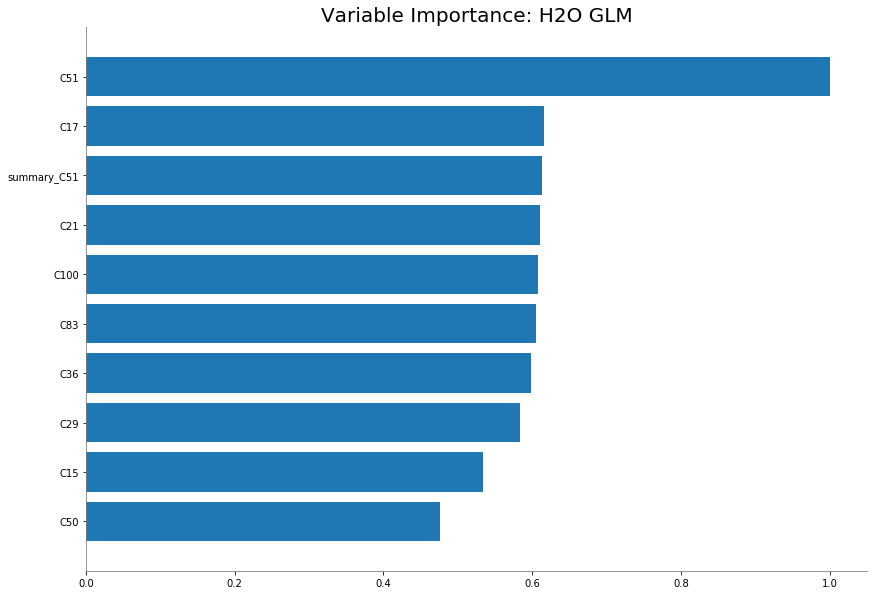

In [35]:
glm_logistic_plus_summary.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


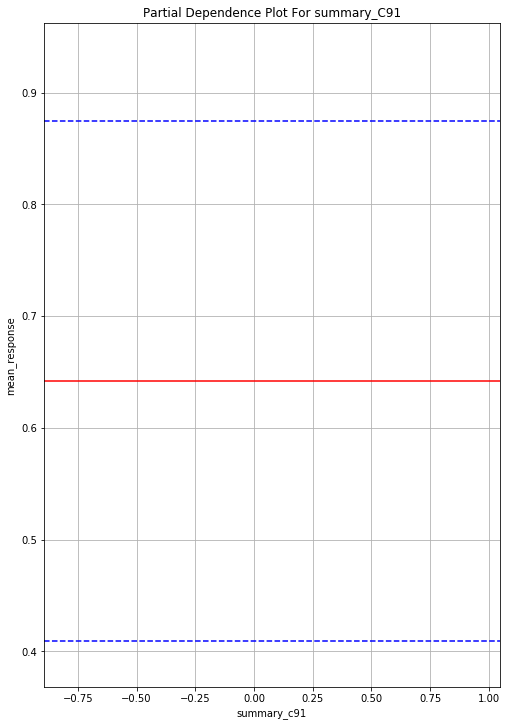

In [36]:
pdp_word_vecs = glm_logistic_plus_summary.partial_plot(data = ext_train_new, cols = ["summary_C91"])

### 2.2.3 Matrix

In [37]:
print("With Summary and Review Embeddings AUC: " + str(round(glm_logistic_plus_summary.auc(valid = True), 3)))

With Summary and Review Embeddings AUC: 0.855


In [38]:
glm_logistic_plus_summary.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5021467831125499: 


,0,1,Error,Rate
0,2618.0,1594.0,0.3784,(1594.0/4212.0)
1,633.0,6307.0,0.0912,(633.0/6940.0)
Total,3251.0,7901.0,0.1997,(2227.0/11152.0)


In [39]:
glm_logistic_plus_summary.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5021467831125499: 


,0,1,Error,Rate
0,2618.0,1594.0,0.3784,(1594.0/4212.0)
1,633.0,6307.0,0.0912,(633.0/6940.0)
Total,3251.0,7901.0,0.1997,(2227.0/11152.0)


## 2.3 Decision Tree

In [40]:
from h2o.estimators.random_forest import H2ORandomForestEstimator # for single tree
# in-notebook display
from IPython.display import Image
from IPython.display import display
%matplotlib inline

### 2.3.1 Train & Fit Model

In [41]:
predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time'] + review_vecs.names + summary_vecs.names
response = 'PositiveReview'

In [42]:
# initialize single tree surrogate model
model_id = 'dt_surrogate_mojo'

# train single tree surrogate model
surrogate = H2OGradientBoostingEstimator(ntrees=1,
                                         sample_rate=1,
                                         col_sample_rate=1,
                                         max_depth=3,
                                         seed=12345,
                                         model_id=model_id)

_ = surrogate.train(x=predictors, y=response, training_frame=ext_train_new)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


### 2.3.2 Interpretability

### 3.3 Matrix

In [43]:
print(surrogate)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  dt_surrogate_mojo


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.2240243687513492
RMSE: 0.4733121261401922
LogLoss: 0.6397027506975472
Mean Per-Class Error: 0.34342953260100517
AUC: 0.7065069169486801
pr_auc: 0.44590818082258726
Gini: 0.4130138338973601
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.618467952665474: 


,0,1,Error,Rate
0,2311.0,13583.0,0.8546,(13583.0/15894.0)
1,671.0,27837.0,0.0235,(671.0/28508.0)
Total,2982.0,41420.0,0.321,(14254.0/44402.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6184680,0.7961618,6.0
max f2,0.5993574,0.8996806,7.0
max f0point5,0.6392298,0.7499928,3.0
max accuracy,0.6310742,0.6918832,5.0
max precision,0.6602216,0.8259918,0.0
max recall,0.5993574,1.0,7.0
max specificity,0.6602216,0.8449100,0.0
max absolute_mcc,0.6424581,0.3020736,2.0
max min_per_class_accuracy,0.6424581,0.6460299,2.0
max mean_per_class_accuracy,0.6424581,0.6565705,2.0


Gains/Lift Table: Avg response rate: 64.20 %, avg score: 64.19 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.3190397,0.6602216,1.2865051,1.2865051,0.8259918,0.6602216,0.8259918,0.6602216,0.4104462,0.4104462,28.6505136,28.6505136
,2,0.4585829,0.6512197,1.1437623,1.2430696,0.7343447,0.6512197,0.7981043,0.6574824,0.1596043,0.5700505,14.3762280,24.3069583
,3,0.5550200,0.6424581,1.0064641,1.2019584,0.6461934,0.6424581,0.7717091,0.6548719,0.0970605,0.6671110,0.6464077,20.1958368
,4,0.6266610,0.6392298,0.9562564,1.1738693,0.6139579,0.6392298,0.7536748,0.6530837,0.0685071,0.7356181,-4.3743596,17.3869313
,5,0.8615603,0.6310742,0.8317765,1.0805997,0.5340364,0.6311718,0.6937917,0.6471095,0.1953838,0.9310018,-16.8223456,8.0599738
,6,0.9328409,0.6184680,0.6377744,1.0467624,0.4094787,0.6184680,0.6720666,0.6449209,0.0454609,0.9764627,-36.2225620,4.6762407
,7,1.0,0.5993574,0.3504699,1.0,0.2250168,0.5993574,0.6420432,0.6418609,0.0235373,1.0,-64.9530149,0.0



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-04-21 14:44:16,0.008 sec,0.0,0.4793994,0.6522336,0.5,0.0,1.0,0.3579568
,2019-04-21 14:44:17,0.407 sec,1.0,0.4733121,0.6397028,0.7065069,0.4459082,1.2865051,0.3210216


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
summary_C51,583.0717163,1.0,0.4330695
C51,260.8253174,0.4473297,0.1937249
summary_C40,154.7588196,0.2654199,0.1149453
summary_C100,131.2238617,0.2250561,0.0974649
summary_C12,106.2958908,0.1823033,0.0789500
---,---,---,---
summary_C95,0.0,0.0,0.0
summary_C96,0.0,0.0,0.0
summary_C97,0.0,0.0,0.0
summary_C98,0.0,0.0,0.0



See the whole table with table.as_data_frame()



## 4 Gradient Boosting

### 4.1 Train & Fit Model

In [44]:
gbm = H2OGradientBoostingEstimator(stopping_metric = "AUC",
                                           stopping_tolerance = 0.001,
                                           stopping_rounds = 5, 
                                           score_tree_interval = 10, 
                                           model_id = 'gbm.hex')
gbm.train(x = predictors, 
                   y = response,
                  training_frame = ext_train_new,
                  validation_frame = ext_test_new)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


### 4.2 Interpretability

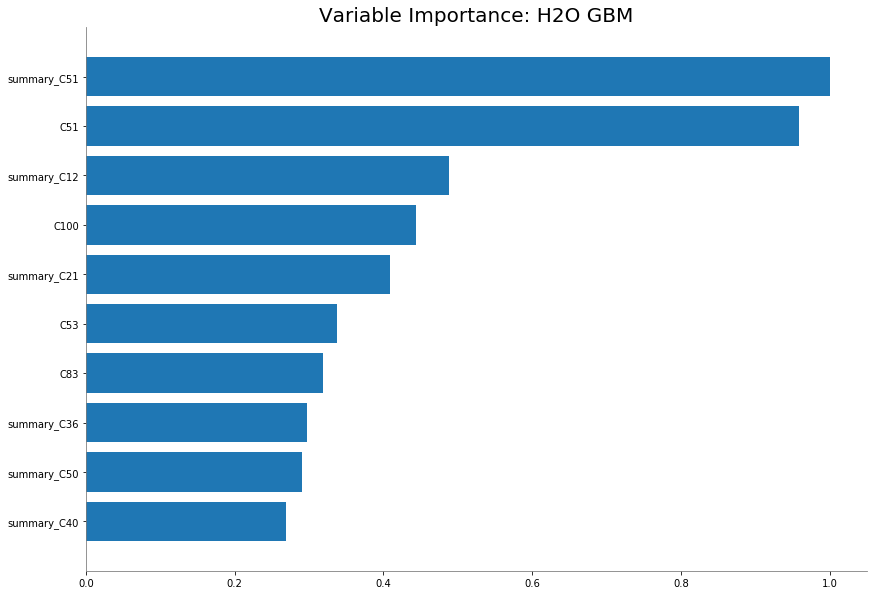

In [45]:
gbm.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


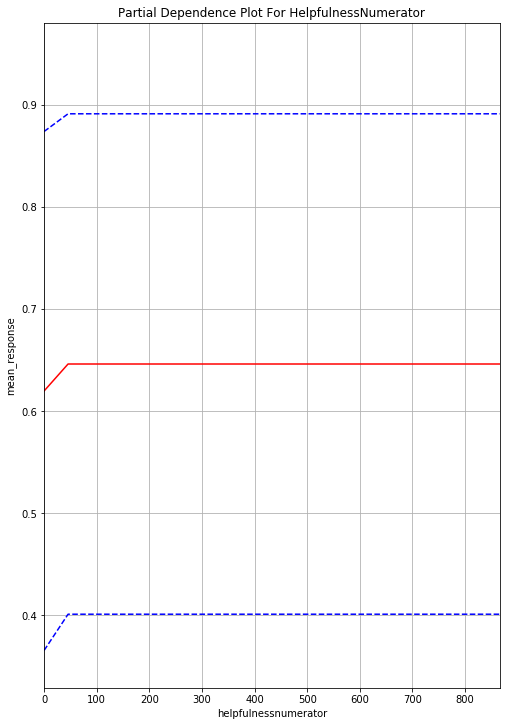

In [46]:
pdp_helpfulness = gbm.partial_plot(ext_train_new, cols = ['HelpfulnessNumerator'])

### 4.3 Matrix

In [47]:
print("AUC on validation data: " + str(round(gbm.auc(valid = True), 3)))

AUC on validation data: 0.846


In [48]:
gbm.confusion_matrix(valid=True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47887123153948047: 


,0,1,Error,Rate
0,2446.0,1766.0,0.4193,(1766.0/4212.0)
1,555.0,6385.0,0.08,(555.0/6940.0)
Total,3001.0,8151.0,0.2081,(2321.0/11152.0)


In [49]:
gbm.r2(train=True, valid=True)

{'train': 0.44591204451732713, 'valid': 0.357253899124959}

In [ ]:
# h2o.cluster().shutdown()